In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

import sklearn as sk

plt.rcParams['figure.figsize'] = 16, 12
plt.rcParams['axes.grid'] = True

!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

from matplotlib.backends.backend_pdf import PdfPages

In [5]:
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Import the data
data = pd.read_csv('CC_GENERAL.csv')

In [3]:
data

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


### Basic User Defined Functions's

In [6]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [7]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [8]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [ ]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = False)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### Data Analysis/Cleaning/Visualisation 

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [10]:
data.drop(columns=['CUST_ID'],inplace= True)

In [11]:
data

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [15]:
data.apply(lambda x:continuous_var_summary(x)).round(2).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,14002049.71,1564.47,873.39,2081.53,4332774.97,0.00,0.07,8.81,23.58,128.28,873.39,2054.14,4338.56,5909.11,9338.80,19043.14
BALANCE_FREQUENCY,8950.0,0.0,7851.57,0.88,1.00,0.24,0.06,0.00,0.09,0.27,0.45,0.89,1.00,1.00,1.00,1.00,1.00,1.00
PURCHASES,8950.0,0.0,8978683.26,1003.20,361.28,2136.63,4565208.19,0.00,0.00,0.00,0.00,39.64,361.28,1110.13,2542.62,3998.62,8977.29,49039.57
ONEOFF_PURCHASES,8950.0,0.0,5302314.47,592.44,38.00,1659.89,2755227.90,0.00,0.00,0.00,0.00,0.00,38.00,577.41,1600.10,2671.09,6689.90,40761.25
INSTALLMENTS_PURCHASES,8950.0,0.0,3679055.42,411.07,89.00,904.34,817827.43,0.00,0.00,0.00,0.00,0.00,89.00,468.64,1140.07,1750.09,3886.24,22500.00
CASH_ADVANCE,8950.0,0.0,8760896.46,978.87,0.00,2097.16,4398096.33,0.00,0.00,0.00,0.00,0.00,0.00,1113.82,3065.53,4647.17,9588.16,47137.21
PURCHASES_FREQUENCY,8950.0,0.0,4388.64,0.49,0.50,0.40,0.16,0.00,0.00,0.00,0.00,0.08,0.50,0.92,1.00,1.00,1.00,1.00
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,1812.00,0.20,0.08,0.30,0.09,0.00,0.00,0.00,0.00,0.00,0.08,0.30,0.75,1.00,1.00,1.00
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,3261.71,0.36,0.17,0.40,0.16,0.00,0.00,0.00,0.00,0.00,0.17,0.75,1.00,1.00,1.00,1.00
CASH_ADVANCE_FREQUENCY,8950.0,0.0,1209.54,0.14,0.00,0.20,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.22,0.42,0.58,0.83,1.50


In [16]:
#outlier imputation
data = data.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [17]:
#Missing imputation
data = data.apply(missing_imputation)

In [20]:
data.apply(continuous_var_summary).T.to_csv('Final_cont_var_sum.csv')

In [21]:
#Creating a new columns which can be defined as a important KPI
data['Purchase_type'] = np.where((data['INSTALLMENTS_PURCHASES']>0)&(data['ONEOFF_PURCHASES']==0),'Installments',
                                 np.where((data['INSTALLMENTS_PURCHASES']==0)&(data['ONEOFF_PURCHASES']>0),'One-off',
                                         np.where((data['INSTALLMENTS_PURCHASES']>0)&(data['ONEOFF_PURCHASES']>0),'Both','Cash')))

In [22]:
data

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Purchase_type
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2.0,1000.0,201.802084,139.509787,0.000000,12,Installments
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0.0,7000.0,4103.032597,1072.340217,0.222222,12,Cash
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12.0,7500.0,622.066742,627.284787,0.000000,12,One-off
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1.0,7500.0,0.000000,767.303879,0.000000,12,One-off
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1.0,1200.0,678.334763,244.791237,0.000000,12,One-off
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6.0,1000.0,325.594462,48.886365,0.500000,6,Installments
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6.0,1000.0,275.861322,767.303879,0.000000,6,Installments
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5.0,1000.0,81.270775,82.418369,0.250000,6,Installments
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0.0,500.0,52.549959,55.755628,0.250000,6,Cash


In [28]:
#Creating Dummies
cat_vars = data[['Purchase_type']]

# for c_feature in categorical_features
for c_feature in ['Purchase_type']:
    cat_vars[c_feature] = cat_vars[c_feature].astype('category')
    cat_vars = create_dummies(cat_vars, c_feature)
    
cat_vars.head() 

C:\Users\Vikas raj purohit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Purchase_type_Both,Purchase_type_Cash,Purchase_type_Installments,Purchase_type_One-off
0,0,0,1,0
1,0,1,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [30]:
data.drop(columns=['Purchase_type'],inplace=True)

In [32]:
#final_data
data = pd.concat([data, cat_vars],axis = 1)

In [33]:
data

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Purchase_type_Both,Purchase_type_Cash,Purchase_type_Installments,Purchase_type_One-off
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,...,2.0,1000.0,201.802084,139.509787,0.000000,12,0,0,1,0
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,...,0.0,7000.0,4103.032597,1072.340217,0.222222,12,0,1,0,0
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,...,12.0,7500.0,622.066742,627.284787,0.000000,12,0,0,0,1
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,...,1.0,7500.0,0.000000,767.303879,0.000000,12,0,0,0,1
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,...,1.0,1200.0,678.334763,244.791237,0.000000,12,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,...,6.0,1000.0,325.594462,48.886365,0.500000,6,0,0,1,0
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,...,6.0,1000.0,275.861322,767.303879,0.000000,6,0,0,1,0
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,...,5.0,1000.0,81.270775,82.418369,0.250000,6,0,0,1,0
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,...,0.0,500.0,52.549959,55.755628,0.250000,6,0,1,0,0


In [34]:
data.drop(columns=['ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES'],inplace=True)

In [42]:
#Deriving new column from two columns
data['paymt_ratio']=(data.PAYMENTS/data.MINIMUM_PAYMENTS)*100
data['paymt_ratio'].head()

0    144.650844
1    382.624146
2     99.168154
3      0.000000
4    277.107453
Name: paymt_ratio, dtype: float64

In [43]:
#delete unneccessary columns
data.drop(columns=['MINIMUM_PAYMENTS','PAYMENTS'],inplace=True)

In [48]:
#Deriving new column from two columns
data['Limit_ratio']=(data.BALANCE/data.CREDIT_LIMIT)*100
data['Limit_ratio'].head()

0     4.090075
1    45.749535
2    33.268651
3    22.222274
4    68.142861
Name: Limit_ratio, dtype: float64

In [50]:
data.drop(columns=['BALANCE','CREDIT_LIMIT'],inplace=True)

In [51]:
data.corr().to_csv('Correlation.csv')

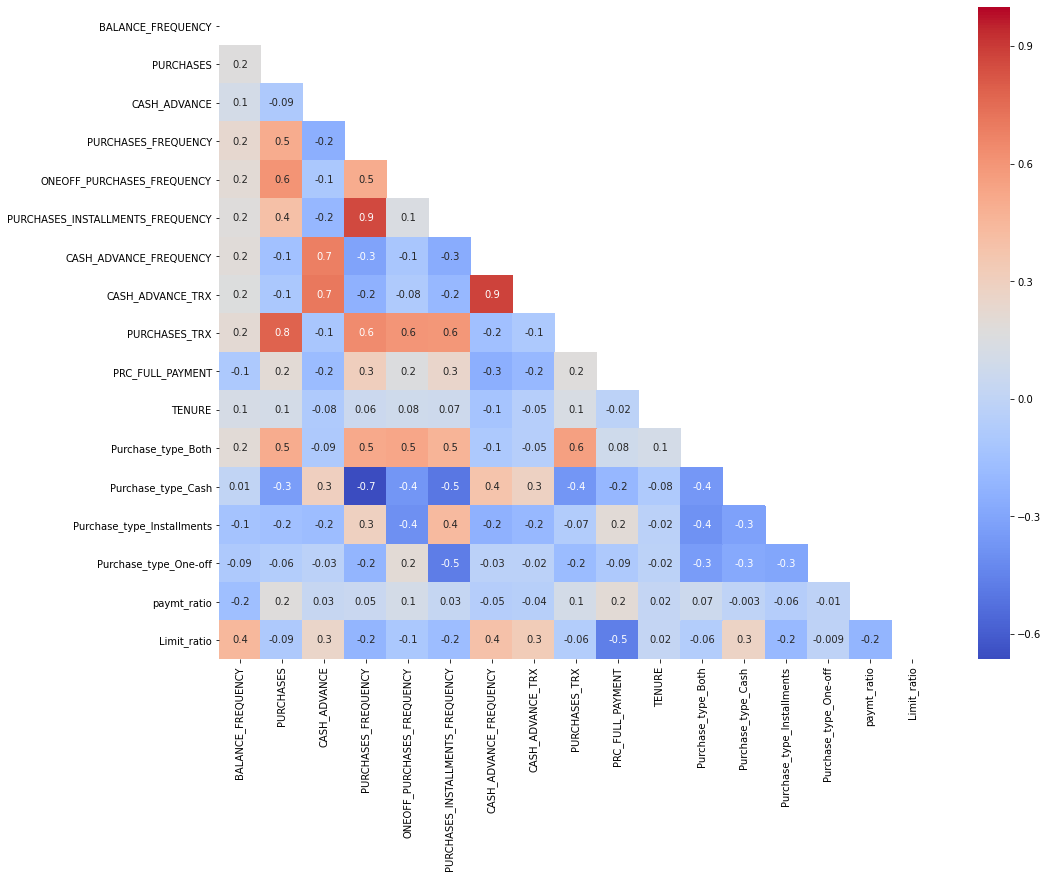

In [52]:
#Correlation Matrix
mask = np.triu(data.corr())
sns.heatmap(data.corr(),annot = True, mask = mask, fmt ='.1g',cmap = 'coolwarm')

In [53]:
#columns Names
data.columns


Index(['BALANCE_FREQUENCY', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'PRC_FULL_PAYMENT', 'TENURE', 'Purchase_type_Both',
       'Purchase_type_Cash', 'Purchase_type_Installments',
       'Purchase_type_One-off', 'paymt_ratio', 'Limit_ratio'],
      dtype='object')

In [54]:
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

In [55]:
#transformation of data
sc = StandardScaler()
data_new = sc.fit_transform(data)

In [57]:
pd.DataFrame(data_new).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.255968,-0.551327,-0.527079,-0.806490,-0.678661,-0.707313,-0.685371,-0.557505,-0.579714,-0.525551,0.36068,-0.670193,-0.543690,1.720516,-0.514625,-0.268383,-0.979686
1,0.132501,-0.613881,3.101370,-1.221758,-0.678661,-0.916995,0.593147,0.166685,-0.675130,0.234227,0.36068,-0.670193,1.839282,-0.581221,-0.514625,-0.111512,0.205564
2,0.520970,-0.106917,-0.527079,1.269843,2.673451,-0.916995,-0.685371,-0.557505,-0.102638,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.298365,-0.149528
3,-1.032906,0.369006,-0.411186,-1.014125,-0.399319,-0.916995,-0.259200,-0.376457,-0.627422,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.363736,-0.463808
4,0.520970,-0.603389,-0.527079,-1.014125,-0.399319,-0.916995,-0.685371,-0.557505,-0.627422,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.181068,0.842675


### Principal Component Analysis

In [58]:

pca = PCA(n_components=17)
pca.fit(data_new)

PCA(copy=True, iterated_power='auto', n_components=17, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [59]:
#variance
pca.explained_variance_

array([4.78182864e+00, 2.86953899e+00, 1.89095015e+00, 1.49487749e+00,
       1.19896702e+00, 9.68589652e-01, 7.99143600e-01, 7.63054828e-01,
       6.27091143e-01, 3.88990572e-01, 3.49552597e-01, 3.10125739e-01,
       2.55578111e-01, 1.63413519e-01, 1.05969956e-01, 3.42276480e-02,
       1.38190101e-31])

In [61]:
sum(pca.explained_variance_)

17.00189965359257

In [62]:
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_
var

array([2.81252609e-01, 1.68777551e-01, 1.11219933e-01, 8.79241452e-02,
       7.05195914e-02, 5.69694959e-02, 4.70031947e-02, 4.48805630e-02,
       3.68835928e-02, 2.28792417e-02, 2.05596201e-02, 1.82406522e-02,
       1.50323268e-02, 9.61148589e-03, 6.23283033e-03, 2.01316610e-03,
       8.12792120e-33])

In [63]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
var1

array([ 28.13,  45.01,  56.13,  64.92,  71.97,  77.67,  82.37,  86.86,
        90.55,  92.84,  94.9 ,  96.72,  98.22,  99.18,  99.8 , 100.  ,
       100.  ])

In [65]:
pd.DataFrame({'Eigen_value': pca.explained_variance_, 'Cumm_variance':var1}, index=range(1,18)).round(4)

,Eigen_value,Cumm_variance
1,4.7818,28.13
2,2.8695,45.01
3,1.8910,56.13
4,1.4949,64.92
5,1.1990,71.97
6,0.9686,77.67
7,0.7991,82.37
8,0.7631,86.86
9,0.6271,90.55
10,0.3890,92.84


###  Based on Eigen_value and Cumm_variance we select 6 as the n_component because 77% variance can be explained by it.

In [66]:
pc_final=PCA(n_components=6).fit(data_new)

In [67]:
pc_final.explained_variance_


array([4.78182864, 2.86953899, 1.89095015, 1.49487749, 1.19896702,
       0.96858965])

In [68]:
red_cr=pc_final.fit_transform(data_new)  # the out put is Factors (F1, F2, ...F9)

In [69]:
dimensions = pd.DataFrame(red_cr)

In [70]:
dimensions.columns = ["C1", "C2", "C3", "C4", "C5", "C6"]

In [71]:
dimensions.head()

,C1,C2,C3,C4,C5,C6
0,-0.476514,-2.205673,-0.627996,-0.400280,-0.084198,0.493510
1,-3.005589,0.908485,-0.443763,1.053702,0.847751,0.572989
2,0.966181,0.124703,2.591733,-1.266947,-1.477335,0.242304
3,-0.991244,-1.196210,2.080660,-0.390123,-0.843420,0.386507
4,-1.258435,-0.824613,1.718076,-1.708859,-0.707558,0.504824


In [72]:
var_list = ['BALANCE_FREQUENCY', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'PRC_FULL_PAYMENT', 'TENURE', 'Purchase_type_Both',
       'Purchase_type_Cash', 'Purchase_type_Installments',
       'Purchase_type_One-off', 'paymt_ratio', 'Limit_ratio']

In [73]:
data_new1=pd.DataFrame(data_new, columns=data.columns)
data_new1.head(5)

data_new2=data_new1[var_list]
data_new2.head(10)

,BALANCE_FREQUENCY,PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,TENURE,Purchase_type_Both,Purchase_type_Cash,Purchase_type_Installments,Purchase_type_One-off,paymt_ratio,Limit_ratio
0,-0.255968,-0.551327,-0.527079,-0.806490,-0.678661,-0.707313,-0.685371,-0.557505,-0.579714,-0.525551,0.36068,-0.670193,-0.543690,1.720516,-0.514625,-0.268383,-0.979686
1,0.132501,-0.613881,3.101370,-1.221758,-0.678661,-0.916995,0.593147,0.166685,-0.675130,0.234227,0.36068,-0.670193,1.839282,-0.581221,-0.514625,-0.111512,0.205564
2,0.520970,-0.106917,-0.527079,1.269843,2.673451,-0.916995,-0.685371,-0.557505,-0.102638,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.298365,-0.149528
3,-1.032906,0.369006,-0.411186,-1.014125,-0.399319,-0.916995,-0.259200,-0.376457,-0.627422,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.363736,-0.463808
4,0.520970,-0.603389,-0.527079,-1.014125,-0.399319,-0.916995,-0.685371,-0.557505,-0.627422,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.181068,0.842675
5,0.520970,0.260344,-0.527079,0.439310,-0.678661,0.550784,-0.685371,-0.557505,-0.293468,-0.525551,0.36068,-0.670193,-0.543690,1.720516,-0.514625,-0.325397,1.764575
6,0.520970,4.035657,-0.527079,1.269843,2.673451,1.599199,-0.685371,-0.557505,2.378162,2.893453,0.36068,1.492109,-0.543690,-0.581221,-0.514625,1.751085,-0.963859
7,0.520970,-0.327867,-0.527079,1.269843,-0.678661,1.599199,-0.685371,-0.557505,-0.102638,-0.525551,0.36068,-0.670193,-0.543690,1.720516,-0.514625,-0.279599,1.159800
8,0.520970,-0.049006,-0.527079,-0.391225,-0.399319,-0.287947,-0.685371,-0.557505,-0.436591,-0.525551,0.36068,1.492109,-0.543690,-0.581221,-0.514625,-0.218299,-0.683544
9,-1.421375,0.226458,-0.527079,-0.806490,-0.119974,-0.916995,-0.685371,-0.557505,-0.532007,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,0.401762,-1.056680


### Lets try to fit 3-8 cluster solution

In [75]:
km_3=KMeans(n_clusters=3,random_state=123).fit(data_new2)
km_4=KMeans(n_clusters=4,random_state=123).fit(data_new2)
#km_5.labels_a

km_5=KMeans(n_clusters=5,random_state=123).fit(data_new2)
#km_5.labels_

km_6=KMeans(n_clusters=6,random_state=123).fit(data_new2)
#km_6.labels_

km_7=KMeans(n_clusters=7,random_state=123).fit(data_new2)
#km_7.labels_

km_8=KMeans(n_clusters=8,random_state=123).fit(data_new2)
#km_5.labels_

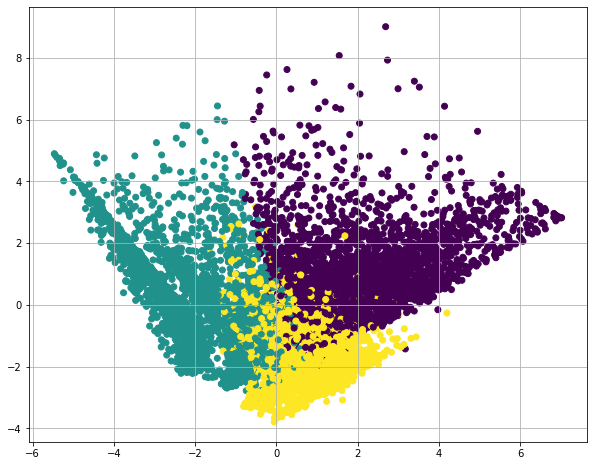

In [78]:
plt.figure(figsize=(10, 8))
plt.scatter(red_cr[:,0], red_cr[:,1], c=km_3.labels_.astype(float))

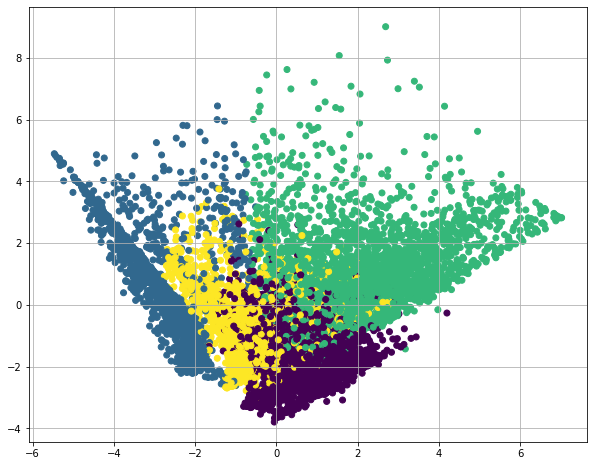

In [79]:
plt.figure(figsize=(10, 8))
plt.scatter(red_cr[:,0], red_cr[:,1], c=km_4.labels_.astype(float))

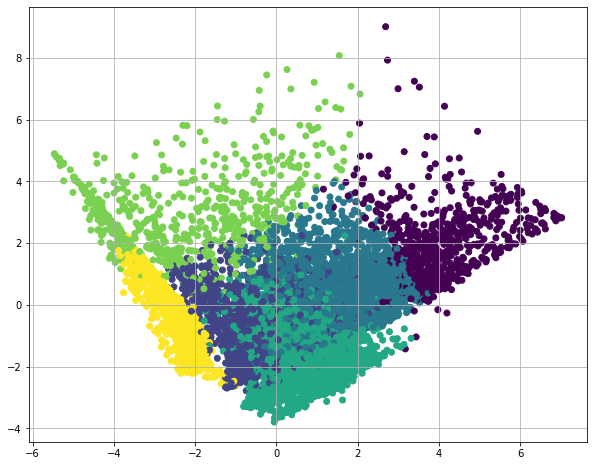

In [80]:
plt.figure(figsize=(10, 8))
plt.scatter(red_cr[:,0], red_cr[:,1], c=km_6.labels_.astype(float))

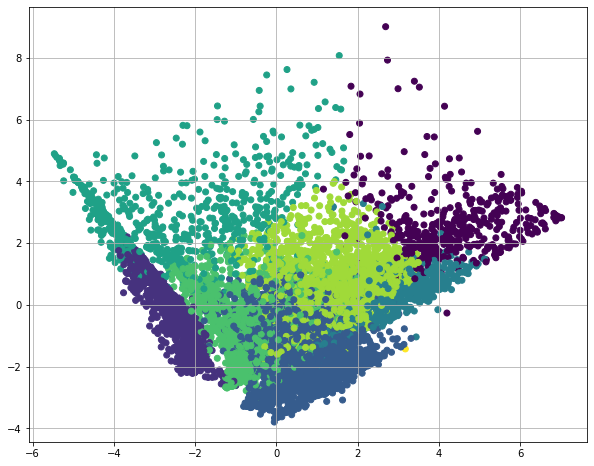

In [127]:
plt.figure(figsize=(10, 8))
plt.scatter(red_cr[:,0], red_cr[:,1], c=km_8.labels_.astype(float))

In [81]:
data['cluster_3'] = km_3.labels_
data['cluster_4'] = km_4.labels_
data['cluster_5'] = km_5.labels_
data['cluster_6'] = km_6.labels_
data['cluster_7'] = km_7.labels_
data['cluster_8'] = km_8.labels_

In [82]:
data

,BALANCE_FREQUENCY,PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,...,Purchase_type_Installments,Purchase_type_One-off,paymt_ratio,Limit_ratio,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.818182,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2.0,0.000000,...,1,0,144.650844,4.090075,2,0,2,3,1,2
1,0.909091,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0.0,0.222222,...,0,0,382.624146,45.749535,1,1,1,5,5,1
2,1.000000,773.17,0.000000,1.000000,1.000000,0.000000,0.000000,0,12.0,0.000000,...,0,1,99.168154,33.268651,0,3,0,1,6,5
3,0.636364,1499.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1.0,0.000000,...,0,1,0.000000,22.222274,1,3,0,1,6,5
4,1.000000,16.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1.0,0.000000,...,0,1,277.107453,68.142861,1,3,0,1,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,1.000000,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6.0,0.500000,...,1,0,666.023056,2.849352,2,0,2,3,4,2
8946,1.000000,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6.0,0.000000,...,1,0,35.952030,1.918322,2,0,2,3,1,2
8947,0.833333,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5.0,0.250000,...,1,0,98.607599,2.339867,2,0,2,3,4,2
8948,0.833333,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0.0,0.250000,...,0,0,94.250501,2.691513,1,1,1,5,5,1


In [83]:
pd.Series(km_3.labels_).value_counts()/sum(pd.Series(km_3.labels_).value_counts())

1    0.432179
0    0.324134
2    0.243687
dtype: float64

In [84]:
pd.Series(km_4.labels_).value_counts()/sum(pd.Series(km_4.labels_).value_counts())

2    0.298101
1    0.260223
0    0.243911
3    0.197765
dtype: float64

In [85]:
pd.Series(km_5.labels_).value_counts()/sum(pd.Series(km_5.labels_).value_counts())

4    0.281788
2    0.242235
1    0.203240
0    0.188939
3    0.083799
dtype: float64

In [86]:
pd.Series(km_6.labels_).value_counts()/sum(pd.Series(km_6.labels_).value_counts())

3    0.242011
2    0.211061
5    0.201453
1    0.185698
4    0.080335
0    0.079441
dtype: float64

In [87]:
pd.Series(km_7.labels_).value_counts()/sum(pd.Series(km_7.labels_).value_counts())

2    0.208268
5    0.201341
6    0.186145
4    0.124469
1    0.121453
3    0.080000
0    0.078324
dtype: float64

In [88]:
pd.Series(km_8.labels_).value_counts()/sum(pd.Series(km_8.labels_).value_counts())

2    0.241899
1    0.201117
6    0.186369
5    0.179665
4    0.078547
3    0.060559
0    0.051285
7    0.000559
dtype: float64

### Silhotee Score

In [90]:
# calculate SC for K=3
from sklearn import metrics
metrics.silhouette_score(data_new2, km_8.labels_)

0.27852264971014284

In [91]:
# calculate SC for K=3 through K=12
k_range = range(3,9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(data_new2)
    scores.append(metrics.silhouette_score(data_new2, km.labels_))

In [92]:
scores

[0.23401064991953133,
 0.273921821826951,
 0.28745283195509796,
 0.280982837382397,
 0.2611496594594148,
 0.27852264971014284]

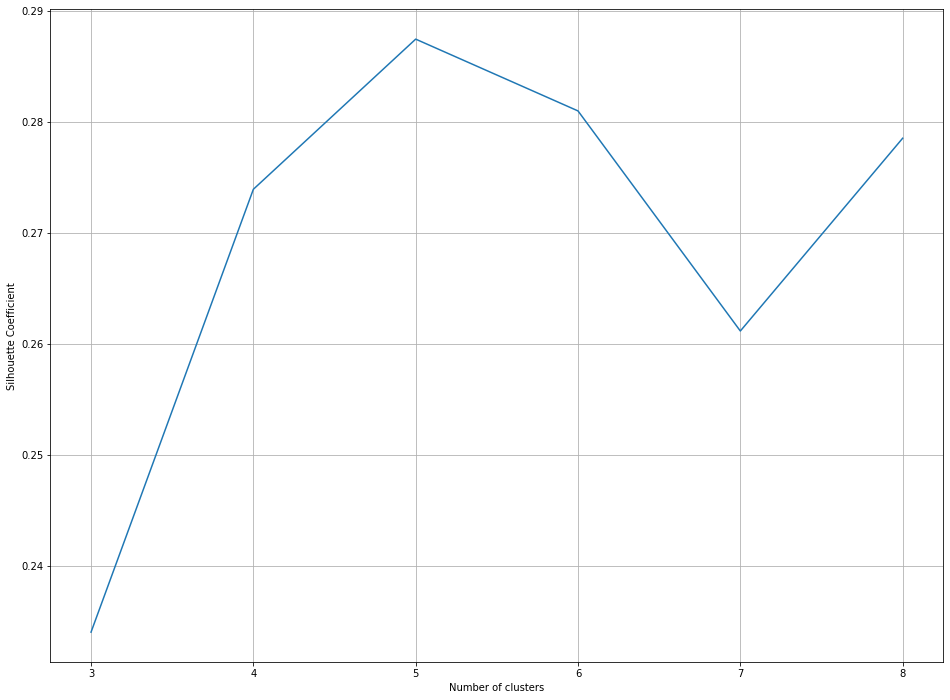

In [93]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

### Elbow Analysis

In [94]:
cluster_range = range( 2, 20 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( data_new2 )
    cluster_errors.append( clusters.inertia_ )

In [95]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,num_clusters,cluster_errors
0,2,121391.465294
1,3,103470.312893
2,4,89275.392737
3,5,80826.755753
4,6,73682.415080
5,7,70162.501904
6,8,64513.226113
7,9,62027.294761
8,10,58711.332641
9,11,55918.499599


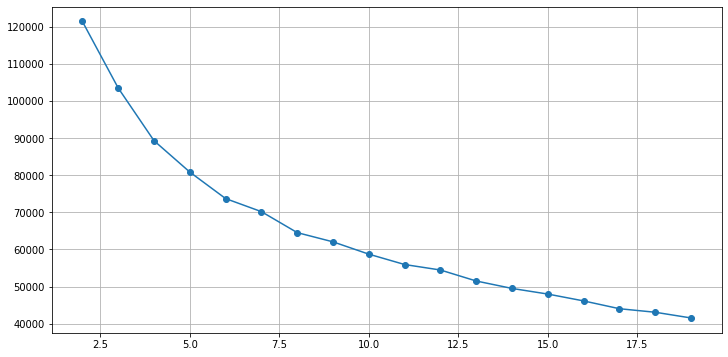

In [96]:
# allow plots to appear in the notebook
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [98]:
data.head()

,BALANCE_FREQUENCY,PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,...,Purchase_type_Installments,Purchase_type_One-off,paymt_ratio,Limit_ratio,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.818182,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2.0,0.000000,...,1,0,144.650844,4.090075,2,0,2,3,1,2
1,0.909091,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0.0,0.222222,...,0,0,382.624146,45.749535,1,1,1,5,5,1
2,1.000000,773.17,0.000000,1.000000,1.000000,0.000000,0.000000,0,12.0,0.000000,...,0,1,99.168154,33.268651,0,3,0,1,6,5
3,0.636364,1499.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1.0,0.000000,...,0,1,0.000000,22.222274,1,3,0,1,6,5
4,1.000000,16.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1.0,0.000000,...,0,1,277.107453,68.142861,1,3,0,1,6,5


In [101]:
pd.Series.sort_index(data.cluster_5.value_counts())

0    1691
1    1819
2    2168
3     750
4    2522
Name: cluster_5, dtype: int64

In [102]:
C5=pd.concat([data_new2,pd.Series(km_5.labels_,name='cluster_5')],axis=1)

In [104]:
# Mean value of each variable group by Cluster- 5
cluster_5_output=C5.groupby('cluster_5').apply(lambda x: x[var_list].mean()).T
cluster_5_output

cluster_5,0,1,2,3,4
BALANCE_FREQUENCY,-0.262904,-0.022549,-0.259293,0.394302,0.298179
PURCHASES,-0.140433,-0.613228,-0.277580,-0.157418,0.821883
CASH_ADVANCE,-0.277207,0.300916,-0.400286,2.188719,-0.337957
PURCHASES_FREQUENCY,-0.423467,-1.219095,0.524855,-0.318067,0.806614
ONEOFF_PURCHASES_FREQUENCY,0.393624,-0.677227,-0.678274,-0.063857,0.826586
PURCHASES_INSTALLMENTS_FREQUENCY,-0.914953,-0.915151,0.755953,-0.321449,0.719280
CASH_ADVANCE_FREQUENCY,-0.294150,0.471913,-0.514395,2.261679,-0.373534
CASH_ADVANCE_TRX,-0.303653,0.227399,-0.443765,2.558442,-0.339774
PURCHASES_TRX,-0.369741,-0.674343,-0.121859,-0.177028,0.891682
PRC_FULL_PAYMENT,-0.172383,-0.375771,0.374492,-0.374054,0.175920


In [105]:
size=pd.concat([pd.Series(data.cluster_3.size), pd.Series.sort_index(data.cluster_3.value_counts()), pd.Series.sort_index(data.cluster_4.value_counts()),
           pd.Series.sort_index(data.cluster_5.value_counts()), pd.Series.sort_index(data.cluster_6.value_counts()),
           pd.Series.sort_index(data.cluster_7.value_counts()), pd.Series.sort_index(data.cluster_8.value_counts())])

In [106]:
size

0    8950
0    2901
1    3868
2    2181
0    2183
1    2329
2    2668
3    1770
0    1691
1    1819
2    2168
3     750
4    2522
0     711
1    1662
2    1889
3    2166
4     719
5    1803
0     701
1    1087
2    1864
3     716
4    1114
5    1802
6    1666
0     459
1    1800
2    2165
3     542
4     703
5    1608
6    1668
7       5
dtype: int64

In [107]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/data.cluster_3.size, columns=['Seg_Pct'])

In [108]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.324134,0.432179,0.243687,0.243911,0.260223,0.298101,0.197765,0.188939,0.20324,...,0.201341,0.186145,0.051285,0.201117,0.241899,0.060559,0.078547,0.179665,0.186369,0.000559


In [109]:
pd.concat([Seg_size.T, Seg_Pct.T], axis=0)


,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.0,2901.000000,3868.000000,2181.000000,2183.000000,2329.000000,2668.000000,1770.000000,1691.000000,1819.00000,...,1802.000000,1666.000000,459.000000,1800.000000,2165.000000,542.000000,703.000000,1608.000000,1668.000000,5.000000
Seg_Pct,1.0,0.324134,0.432179,0.243687,0.243911,0.260223,0.298101,0.197765,0.188939,0.20324,...,0.201341,0.186145,0.051285,0.201117,0.241899,0.060559,0.078547,0.179665,0.186369,0.000559


In [111]:
data.head(10)


,BALANCE_FREQUENCY,PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,...,Purchase_type_Installments,Purchase_type_One-off,paymt_ratio,Limit_ratio,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,0.818182,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2.0,0.000000,...,1,0,144.650844,4.090075,2,0,2,3,1,2
1,0.909091,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0.0,0.222222,...,0,0,382.624146,45.749535,1,1,1,5,5,1
2,1.000000,773.17,0.000000,1.000000,1.000000,0.000000,0.000000,0,12.0,0.000000,...,0,1,99.168154,33.268651,0,3,0,1,6,5
3,0.636364,1499.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1.0,0.000000,...,0,1,0.000000,22.222274,1,3,0,1,6,5
4,1.000000,16.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1.0,0.000000,...,0,1,277.107453,68.142861,1,3,0,1,6,5
5,1.000000,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8.0,0.000000,...,1,0,58.160144,100.546042,2,0,2,3,1,2
6,1.000000,7091.01,0.000000,1.000000,1.000000,1.000000,0.000000,0,64.0,1.000000,...,0,0,3208.181984,4.646376,0,2,4,0,3,0
7,1.000000,436.20,0.000000,1.000000,0.000000,1.000000,0.000000,0,12.0,0.000000,...,1,0,127.635658,79.289250,2,0,2,3,1,2
8,1.000000,861.49,0.000000,0.333333,0.083333,0.250000,0.000000,0,5.0,0.000000,...,0,0,220.627980,14.498950,0,2,4,2,2,6
9,0.545455,1281.60,0.000000,0.166667,0.166667,0.000000,0.000000,0,3.0,0.000000,...,0,1,1161.260542,1.383873,1,3,0,1,6,5


In [112]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([data.apply(lambda x: x.mean()).T, data.groupby('cluster_3').apply(lambda x: x.mean()).T, data.groupby('cluster_4').apply(lambda x: x.mean()).T,
        data.groupby('cluster_5').apply(lambda x: x.mean()).T, data.groupby('cluster_6').apply(lambda x: x.mean()).T,
          data.groupby('cluster_7').apply(lambda x: x.mean()).T, data.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)


In [113]:
Profling_output

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
BALANCE_FREQUENCY,0.878083,0.949983,0.857579,0.818812,0.818125,0.893586,0.950434,0.822576,0.816559,0.872806,...,0.872021,0.820091,0.992236,0.873759,0.817956,0.915455,0.968622,0.816231,0.940139,0.400000
PURCHASES,936.229237,2174.768307,240.756789,522.238216,519.727888,60.994277,2184.353358,720.212011,722.055038,0.995250,...,0.000000,681.257083,5567.515251,0.119633,508.822827,2159.265886,605.793073,646.005715,1250.552794,210.304000
CASH_ADVANCE,935.920972,534.314805,1612.743091,269.763951,249.795823,2263.272686,573.037836,582.577055,443.691135,1470.250756,...,1453.437157,457.303766,565.480188,1443.526777,226.569367,73.616722,4966.432594,474.855489,427.137931,4146.069282
PURCHASES_FREQUENCY,0.490351,0.829984,0.113501,0.706938,0.703828,0.043016,0.817947,0.321873,0.320393,0.001069,...,0.000185,0.316064,0.976309,0.000478,0.701086,0.876863,0.338849,0.295664,0.738550,0.200000
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.493701,0.098118,0.000115,0.000210,0.017825,0.450245,0.321339,0.319883,0.000428,...,0.000000,0.315864,0.761715,0.000000,0.000000,0.614151,0.172927,0.295456,0.319397,0.016667
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.598994,0.015873,0.670626,0.667397,0.025568,0.653560,0.000870,0.000812,0.000733,...,0.000185,0.000000,0.849677,0.000478,0.665024,0.558849,0.215916,0.000000,0.584766,0.200000
CASH_ADVANCE_FREQUENCY,0.134017,0.082943,0.226832,0.037344,0.036356,0.307212,0.088775,0.094767,0.076499,0.226294,...,0.225643,0.078261,0.076905,0.226171,0.033517,0.012917,0.585235,0.081098,0.081025,0.100000
CASH_ADVANCE_TRX,3.079330,1.982075,5.230869,0.723063,0.699496,7.306140,2.127061,1.888136,1.402129,4.335349,...,4.294118,1.445978,1.934641,4.296667,0.625866,0.241697,17.586060,1.504353,1.596523,1.400000
PURCHASES_TRX,14.151385,31.872248,2.179162,11.813164,11.709350,0.811936,32.896882,6.459610,6.401248,0.016493,...,0.001665,6.207989,80.016057,0.005000,11.559589,28.788764,9.133713,5.778302,20.119904,3.200000
PRC_FULL_PAYMENT,0.153715,0.212598,0.048233,0.262463,0.263142,0.042305,0.196124,0.101423,0.103295,0.043808,...,0.044110,0.098284,0.203170,0.043088,0.262226,0.762478,0.043989,0.067669,0.050103,0.128571


In [114]:
Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)

In [115]:
Profling_output_final


,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950.000000,2901.000000,3868.000000,2181.000000,2183.000000,2329.000000,2668.000000,1770.000000,1691.000000,1819.000000,...,1802.000000,1666.000000,459.000000,1800.000000,2165.000000,542.000000,703.000000,1608.000000,1668.000000,5.000000
Seg_Pct,1.000000,0.324134,0.432179,0.243687,0.243911,0.260223,0.298101,0.197765,0.188939,0.203240,...,0.201341,0.186145,0.051285,0.201117,0.241899,0.060559,0.078547,0.179665,0.186369,0.000559
BALANCE_FREQUENCY,0.878083,0.949983,0.857579,0.818812,0.818125,0.893586,0.950434,0.822576,0.816559,0.872806,...,0.872021,0.820091,0.992236,0.873759,0.817956,0.915455,0.968622,0.816231,0.940139,0.400000
PURCHASES,936.229237,2174.768307,240.756789,522.238216,519.727888,60.994277,2184.353358,720.212011,722.055038,0.995250,...,0.000000,681.257083,5567.515251,0.119633,508.822827,2159.265886,605.793073,646.005715,1250.552794,210.304000
CASH_ADVANCE,935.920972,534.314805,1612.743091,269.763951,249.795823,2263.272686,573.037836,582.577055,443.691135,1470.250756,...,1453.437157,457.303766,565.480188,1443.526777,226.569367,73.616722,4966.432594,474.855489,427.137931,4146.069282
PURCHASES_FREQUENCY,0.490351,0.829984,0.113501,0.706938,0.703828,0.043016,0.817947,0.321873,0.320393,0.001069,...,0.000185,0.316064,0.976309,0.000478,0.701086,0.876863,0.338849,0.295664,0.738550,0.200000
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.493701,0.098118,0.000115,0.000210,0.017825,0.450245,0.321339,0.319883,0.000428,...,0.000000,0.315864,0.761715,0.000000,0.000000,0.614151,0.172927,0.295456,0.319397,0.016667
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.598994,0.015873,0.670626,0.667397,0.025568,0.653560,0.000870,0.000812,0.000733,...,0.000185,0.000000,0.849677,0.000478,0.665024,0.558849,0.215916,0.000000,0.584766,0.200000
CASH_ADVANCE_FREQUENCY,0.134017,0.082943,0.226832,0.037344,0.036356,0.307212,0.088775,0.094767,0.076499,0.226294,...,0.225643,0.078261,0.076905,0.226171,0.033517,0.012917,0.585235,0.081098,0.081025,0.100000
CASH_ADVANCE_TRX,3.079330,1.982075,5.230869,0.723063,0.699496,7.306140,2.127061,1.888136,1.402129,4.335349,...,4.294118,1.445978,1.934641,4.296667,0.625866,0.241697,17.586060,1.504353,1.596523,1.400000


In [116]:
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8',]

In [117]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,2901.000000,3868.000000,2181.000000,2183.000000,2329.000000,2668.000000,1770.000000,1691.000000,1819.000000,...,1802.000000,1666.000000,459.000000,1800.000000,2165.000000,542.000000,703.000000,1608.000000,1668.000000,5.000000
Seg_Pct,1.000000,0.324134,0.432179,0.243687,0.243911,0.260223,0.298101,0.197765,0.188939,0.203240,...,0.201341,0.186145,0.051285,0.201117,0.241899,0.060559,0.078547,0.179665,0.186369,0.000559
BALANCE_FREQUENCY,0.878083,0.949983,0.857579,0.818812,0.818125,0.893586,0.950434,0.822576,0.816559,0.872806,...,0.872021,0.820091,0.992236,0.873759,0.817956,0.915455,0.968622,0.816231,0.940139,0.400000
PURCHASES,936.229237,2174.768307,240.756789,522.238216,519.727888,60.994277,2184.353358,720.212011,722.055038,0.995250,...,0.000000,681.257083,5567.515251,0.119633,508.822827,2159.265886,605.793073,646.005715,1250.552794,210.304000
CASH_ADVANCE,935.920972,534.314805,1612.743091,269.763951,249.795823,2263.272686,573.037836,582.577055,443.691135,1470.250756,...,1453.437157,457.303766,565.480188,1443.526777,226.569367,73.616722,4966.432594,474.855489,427.137931,4146.069282
PURCHASES_FREQUENCY,0.490351,0.829984,0.113501,0.706938,0.703828,0.043016,0.817947,0.321873,0.320393,0.001069,...,0.000185,0.316064,0.976309,0.000478,0.701086,0.876863,0.338849,0.295664,0.738550,0.200000
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.493701,0.098118,0.000115,0.000210,0.017825,0.450245,0.321339,0.319883,0.000428,...,0.000000,0.315864,0.761715,0.000000,0.000000,0.614151,0.172927,0.295456,0.319397,0.016667
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.598994,0.015873,0.670626,0.667397,0.025568,0.653560,0.000870,0.000812,0.000733,...,0.000185,0.000000,0.849677,0.000478,0.665024,0.558849,0.215916,0.000000,0.584766,0.200000
CASH_ADVANCE_FREQUENCY,0.134017,0.082943,0.226832,0.037344,0.036356,0.307212,0.088775,0.094767,0.076499,0.226294,...,0.225643,0.078261,0.076905,0.226171,0.033517,0.012917,0.585235,0.081098,0.081025,0.100000
CASH_ADVANCE_TRX,3.079330,1.982075,5.230869,0.723063,0.699496,7.306140,2.127061,1.888136,1.402129,4.335349,...,4.294118,1.445978,1.934641,4.296667,0.625866,0.241697,17.586060,1.504353,1.596523,1.400000


In [119]:
Profling_output_final.to_csv('Profiling_output.csv')

In [118]:
data_new2.head()

,BALANCE_FREQUENCY,PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,TENURE,Purchase_type_Both,Purchase_type_Cash,Purchase_type_Installments,Purchase_type_One-off,paymt_ratio,Limit_ratio
0,-0.255968,-0.551327,-0.527079,-0.806490,-0.678661,-0.707313,-0.685371,-0.557505,-0.579714,-0.525551,0.36068,-0.670193,-0.543690,1.720516,-0.514625,-0.268383,-0.979686
1,0.132501,-0.613881,3.101370,-1.221758,-0.678661,-0.916995,0.593147,0.166685,-0.675130,0.234227,0.36068,-0.670193,1.839282,-0.581221,-0.514625,-0.111512,0.205564
2,0.520970,-0.106917,-0.527079,1.269843,2.673451,-0.916995,-0.685371,-0.557505,-0.102638,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.298365,-0.149528
3,-1.032906,0.369006,-0.411186,-1.014125,-0.399319,-0.916995,-0.259200,-0.376457,-0.627422,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.363736,-0.463808
4,0.520970,-0.603389,-0.527079,-1.014125,-0.399319,-0.916995,-0.685371,-0.557505,-0.627422,-0.525551,0.36068,-0.670193,-0.543690,-0.581221,1.943162,-0.181068,0.842675


In [120]:
centroids = km_5.cluster_centers_
centroids

array([[-2.62903979e-01, -1.40432891e-01, -2.77207177e-01,
        -4.23467389e-01,  3.93624103e-01, -9.14952695e-01,
        -2.94150402e-01, -3.03652813e-01, -3.69741054e-01,
        -1.72383434e-01, -2.02322842e-02, -6.53569284e-01,
        -5.43690450e-01, -5.81220817e-01,  1.92426761e+00,
        -2.37581430e-02, -9.48842672e-02],
       [-2.25487568e-02, -6.13227988e-01,  3.00916442e-01,
        -1.21909463e+00, -6.77227495e-01, -9.15150817e-01,
         4.71912862e-01,  2.27399053e-01, -6.74342884e-01,
        -3.75771026e-01, -1.38028976e-01, -6.63060149e-01,
         1.82618144e+00, -5.76159273e-01, -5.14625001e-01,
         2.14837399e-03,  4.94771091e-01],
       [-2.59293156e-01, -2.77579561e-01, -4.00286137e-01,
         5.24854870e-01, -6.78274264e-01,  7.55952911e-01,
        -5.14395300e-01, -4.43765415e-01, -1.21859084e-01,
         3.74492439e-01, -3.39658235e-02, -6.68197790e-01,
        -5.43690450e-01,  1.71839312e+00, -5.14625001e-01,
        -9.85081392e-02, -3.7

In [122]:
km_5.predict(data_new2)

array([2, 1, 0, ..., 2, 1, 0])

In [125]:
data_new2['pred_segment'] = pd.Series(km_5.predict(data_new2))

In [126]:
data_new2.head(20)

,BALANCE_FREQUENCY,PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,TENURE,Purchase_type_Both,Purchase_type_Cash,Purchase_type_Installments,Purchase_type_One-off,paymt_ratio,Limit_ratio,pred_segment
0,-0.255968,-0.551327,-0.527079,-0.806490,-0.678661,-0.707313,-0.685371,-0.557505,-0.579714,-0.525551,0.360680,-0.670193,-0.543690,1.720516,-0.514625,-0.268383,-0.979686,2
1,0.132501,-0.613881,3.101370,-1.221758,-0.678661,-0.916995,0.593147,0.166685,-0.675130,0.234227,0.360680,-0.670193,1.839282,-0.581221,-0.514625,-0.111512,0.205564,1
2,0.520970,-0.106917,-0.527079,1.269843,2.673451,-0.916995,-0.685371,-0.557505,-0.102638,-0.525551,0.360680,-0.670193,-0.543690,-0.581221,1.943162,-0.298365,-0.149528,0
3,-1.032906,0.369006,-0.411186,-1.014125,-0.399319,-0.916995,-0.259200,-0.376457,-0.627422,-0.525551,0.360680,-0.670193,-0.543690,-0.581221,1.943162,-0.363736,-0.463808,0
4,0.520970,-0.603389,-0.527079,-1.014125,-0.399319,-0.916995,-0.685371,-0.557505,-0.627422,-0.525551,0.360680,-0.670193,-0.543690,-0.581221,1.943162,-0.181068,0.842675,0
5,0.520970,0.260344,-0.527079,0.439310,-0.678661,0.550784,-0.685371,-0.557505,-0.293468,-0.525551,0.360680,-0.670193,-0.543690,1.720516,-0.514625,-0.325397,1.764575,2
6,0.520970,4.035657,-0.527079,1.269843,2.673451,1.599199,-0.685371,-0.557505,2.378162,2.893453,0.360680,1.492109,-0.543690,-0.581221,-0.514625,1.751085,-0.963859,4
7,0.520970,-0.327867,-0.527079,1.269843,-0.678661,1.599199,-0.685371,-0.557505,-0.102638,-0.525551,0.360680,-0.670193,-0.543690,1.720516,-0.514625,-0.279599,1.159800,2
8,0.520970,-0.049006,-0.527079,-0.391225,-0.399319,-0.287947,-0.685371,-0.557505,-0.436591,-0.525551,0.360680,1.492109,-0.543690,-0.581221,-0.514625,-0.218299,-0.683544,4
9,-1.421375,0.226458,-0.527079,-0.806490,-0.119974,-0.916995,-0.685371,-0.557505,-0.532007,-0.525551,0.360680,-0.670193,-0.543690,-0.581221,1.943162,0.401762,-1.056680,0


### Conclusion : Based on Silhoutee score and profiling we chose 5 clusters